<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/optimization/Taylor_Polynomials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Look at `jax.jvp + vmap`: [here](https://github.com/google/jax/issues/1012), [here](https://github.com/google/jax/pull/2099)
*   [composes forward-mode autodiff with partial evaluation](https://github.com/google/jax/issues/526)




This note follows from a couple of lectures:
*   [Gilbert's Strang's lecture](https://www.youtube.com/watch?v=U0xlKuFqCuI&t=392s), [Linear Algebra](https://www.youtube.com/watch?v=qWTcD_VQd8w&t=5s), [3Blue1Brown](https://www.youtube.com/watch?v=3d6DsjIBzJ4&list=PL0-GT3co4r2wlh6UHTUeQsrf3mlS2lk6x&index=11), [Implicit Layers Tutorial](http://implicit-layers-tutorial.org/implicit_functions/), [Matthew Johnson](https://gist.github.com/mattjj/02ae95e51ead485223245d343efbd461)




In [1]:
#@title Import Modules { display-mode: "form" }
import jax
import jax.numpy as jnp
from jax import random, grad, vmap 
import matplotlib.pyplot as plt 
import seaborn as sns
import altair as alt
import pandas as pd
from functools import partial
from math import factorial 

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style('whitegrid')

### First Order Taylor Polynomials (First-order oracle)

Let's say we want to approximate a function, $f$, at some point, $x_0$.

For example: $f(x): e^x$ around $x_0 = 0.25$

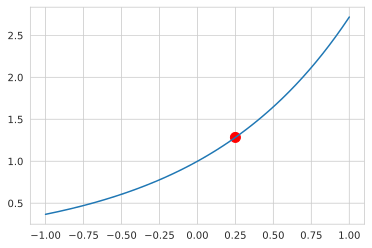

In [2]:


#@title Function { display-mode: "form" }
# The function we want to approximate
def f(x):
  return jnp.exp(x)

x = jnp.linspace(-1, 1, 1000).reshape(-1,1)
y = f(x)

plt.plot(x, y)
plt.scatter(0.25, f(0.25), color='red', s=100)
plt.show()

Let's say that we know the value of a function at a point: $f(x_0)$, as well as the derivative of the function evaluated at the point $f'(x_0)$. Then we can approximate the function around the point via the following function: 
\begin{align*}
f_{x_0}(x) &= f(x_0) + f'(x_0)(x-x_0) \\
\end{align*}
We refer to this function as a taylor polynomial/ taylor approximation. We can motivate this approach by referencing the definition of a derivative.


\begin{align}
f'(x_0) &:= \underset{x \rightarrow x_0}{\textrm{lim}} \frac{f(x) - f(x_0)}{x-x_0} \end{align}
If we know $x$ is reasonably close to $x_0$, then we can say the following:
 \begin{align*}
  f'(x_0) & \approx  \frac{f(x) - f(x_0)}{x - x_0} 
\end{align*}
We can then rearrange terms to get
 \begin{align*}
  f(x) & \approx f(x_0) + f'(x_0)(x-x_0)
\end{align*}
The way to interpret this is that we are approximating the function on the left $f(x)$ via the function on the right: $f(x_0) + f'(x_0)(x-x_0)$. Note this is a function of $x$ but is in some sense **parameterized** by $x_0$. 


### Basic Code

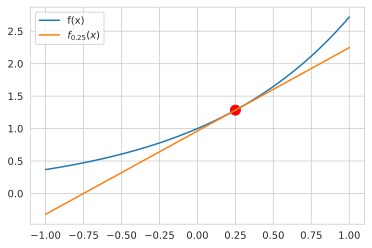

In [5]:
#@title Default title text
### We can define a function
def linear_approx(f, x0, x):
  fx0, f_jvp = jax.linearize(f, x0)
  return fx0 + f_jvp(x-x0)

x = jnp.linspace(-1, 1, 1000)
x0 = 0.25
y = f(x)
y_approx = vmap(partial(linear_approx, f, x0))(x)

plt.plot(x, y, label=r'f(x)')
plt.scatter(0.25, f(0.25), color='red', s=100)
plt.plot(x, y_approx, label=r'$f_{0.25}(x)$')
plt.legend()
plt.show()

### Jacobian Vector Products

Whenever we do something in code, we always want to consider (however briefly), could we make this code better? And in JAX, the answer is almost always yes! because there is always more to understand about the library that often yields improved results.

Here, we are going to consider defining the first order Taylor Polynomial via `jax.jvp`. The Jacobain-Vector Product defined the following mapping. 

### Jacobain Vector Products (i.e first two terms of the Taylor Series)



\begin{align*}
(f, x, v) \rightarrow (f(x), f'(x)v)
\end{align*}

Hopefully it's clear then that if we want to evalutate the first order Taylor Polynomial taken at $x_0$ at the point $x$ then we would make use of the following mapping

\begin{align*}
(f, x_0, x-x_0) \rightarrow (f(x_0), f'(x_0)(x-x_0))
\end{align*}

The first order Taylor Polynomial is simply the sum of these two terms

\begin{align*}
f_{x_0}(x) &= f(x_0) + f'(x_0)(x-x_0)
\end{align*}


In [ ]:
### Define Function
def f(x):
  return jnp.exp(x)

### Let `v` denote how far "away" from `x_0` you want to evaluate the first order taylor polynomial
v = 1.0
y, delta_y = jax.jvp(f, (x_0, ), (v,))

### Effecicient Vectorized Taylor Approximations
- Things to consider: 
  - [Depth of Computation](https://github.com/google/jax/issues/526): "With linearize the memory cost scales with the depth of the computation, since it saves all linearization points (just like reverse-mode's vjp does), whereas for jvp (and hence also vmap'd jvp) the memory cost does not scale with the depth of the computation."
  - "Since we evaluate JVPs as we go, we don’t need to store anything for later, and so the memory cost is independent of the depth of the computation. In addition, the FLOP cost of the jvp-transformed function is about 3x the cost of just evaluating the function (one unit of work for evaluating the original function, for example sin(x); one unit for linearizing, like cos(x); and one unit for applying the linearized function to a vector, like cos_x * v)" - [The Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)


#### `jax.linearize`

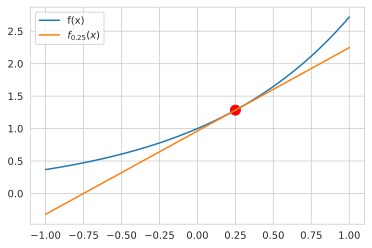

In [ ]:
def f(x):
  return jnp.exp(x)
x = jnp.linspace(-1, 1, 1000).reshape(-1,1)
x_0 = jnp.array([0.25])
y, f_jvp = jax.linearize(f, x_0)
y_approx = y + vmap(f_jvp)(x-x_0)
plt.plot(x, f(x), label=r'f(x)')
plt.scatter(0.25, f(x_0), color='red', s=100)
plt.plot(x, y_approx, label=r'$f_{0.25}(x)$')
plt.legend()
plt.show()

#### `jax.vmap + jax.jvp`

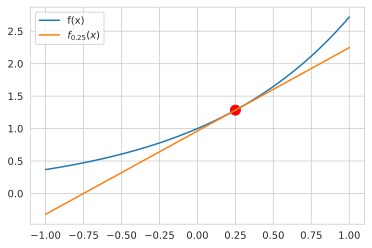

In [ ]:
y, delta_y = vmap(partial(jax.jvp, f, (x_0,)), out_axes=(None, 0))((x-x_0,))
y_approx = y + vmap(f_jvp)(x-x_0)
plt.plot(x, f(x), label=r'f(x)')
plt.scatter(0.25, f(x_0), color='red', s=100)
plt.plot(x, y_approx, label=r'$f_{0.25}(x)$')
plt.legend()
plt.show()

### Second Order Taylor Polynomials

As discussed in class, the first order taylor polnomial defined around a point, $x_0$, shares both the value of $f$ at that point as well as the derivative of $f$ at that point. We also discussed though, how the first order taylor polynomial is a linear function, so, if the function we want to approximate has any type of curvature, our approximation can potentially be poor.

In order to capture the curvature of the underlying/target function, we'll want to add "higher" order derivative information to our approximation. For instance, a natural idea is to add the second derivative of the $f$ evaluated at $x_0$ to our approximation. We do so below:

\begin{align*}
f_{x_0}(x) &= f(x_0) + f'(x_0)(x-x_0) + f''(x_0)(x - x_0)
\end{align*}

From looking at this function, it's not immediately clear that there is a problem with this approximation, but there are! So let's explore this further. Let's first re-write the function to make the following steps of the calculations easier to follow:
\begin{align*}
f_{x_0}(x) &= \underbrace{f'(x_0)x + f''(x_0)x}_{\textrm{Depends on} \ x} - f'(x_0)x_0 - f''(x_0)x_0 + f(x_0) 
\end{align*}
Let's take the derivative of the function
\begin{align*}
\frac{df_{x_0}(x)}{dx} &= f'(x_0) + f''(x_0)
\end{align*}
We see that we have a problem. The derivative of the target function at $x_0$ does not match the derivative of our approximation at $x_0$. Hence, we have to adjust our approximation. What if we, instead, write the approximation as follows:

\begin{align*}
f_{x_0}(x) &= f(x_0) + f'(x_0)(x-x_0) + f''(x_0)(x - x_0)^2 \\
&= f(x_0) + f'(x_0)(x-x_0) + f''(x_0)x^2 + f''(x_0)x_0^2 -2f''(x_0)xx_0 \\  
&= \underbrace{f'(x_0)x + f''(x_0)x^2 -2f''(x_0)xx_0}_{\textrm{Depends on} \ x} + f''(x_0)x_0^2 -f'(x_0)x_0 + f(x_0)   \\ 
\end{align*}
Let's take the derivative of this function. 
\begin{align*}
\frac{df_{x_0}(x)}{dx} &= f'(x_0) + 2f''(x_0)x - 2f''(x_0)x_0
\end{align*}
If we evalute this function at $x=x_0$ we get 
\begin{align*}
\frac{df_{x_0}(x)}{dx}\Big|_{x=x_0} &= f'(x_0) + \underbrace{2f''(x_0)x_0- 2f''(x_0)x_0}_{\textrm{This cancels out}} \\
&=  f'(x_0) 
\end{align*}
So the first derivative of $f$ matches the first derivative of our approximation at $x_0$ which is good. But what about the second derivative?

\begin{align*}
\frac{d^2f_{x_0}(x)}{dx^2} &= 2f''(x_0)
\end{align*}

We see that the derivatives differ by a constant of $2$. To remedy this, we can write the approximation function as follows: 

\begin{align*}
f_{x_0}(x) &= f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x - x_0)^2 
\end{align*}
If you work through the above derivations with this function you will see that it matches the first and second derivative of $f$ at $x_0$.

### Basic Code for Second Order Taylor Polynomial in Jax

Here we see the "power" of jax --> applying arbitrary composition of transformations to functions

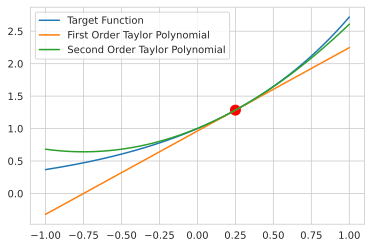

In [ ]:
### We can define a function
def f(x):
  return jnp.exp(x)

def second_order_taylor(f, x_0, x):
  first_deriv = grad(f)(x_0)
  second_deriv = grad(grad(f))(x_0)
  return f(x_0) + first_deriv*(x-x_0) + 0.5*second_deriv*(x-x_0)**2

x = jnp.linspace(-1, 1, 1000).reshape(-1,1)
x_0 = 0.25
y = f(x)
y_first_approx = vmap(partial(linear_approx, f, x_0))(x)
y_second_approx = vmap(partial(second_order_taylor, f, x_0))(x)

plt.plot(x, y, label='Target Function')
plt.scatter(0.25, f(0.25), color='red', s=100)
plt.plot(x, y_first_approx, label='First Order Taylor Polynomial')
plt.plot(x, y_second_approx, label='Second Order Taylor Polynomial')
plt.legend()
plt.show()

### Second Order Taylor Polynomial with `jax.jvp` (following [Matthew Johnson's gist](https://gist.github.com/mattjj/02ae95e51ead485223245d343efbd461))

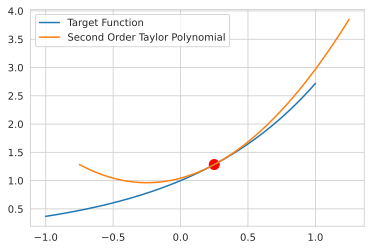

In [ ]:
def second_order_taylor(f, x_0, v):

  """ We compute the first two terms of the Taylor Polynomial"""
  term0, term1 = jax.jvp(f, (x_0,), (v,)) 

  """We now define a new function that takes in `x` and returns f'(x)v"""
  lt = lambda x: jax.jvp(f, (x,), (v,))[1]

  """We now take the Jacobian-Vector Product of this function which will
  return (f'(x)v, f''(x)v^2)
  
  Since we are only interested in the second term, we keep that"""
  term2 = jax.jvp(lt, (x_0,), (v,))[1]
  return term0 + term1 + term2 

x = jnp.linspace(-1, 1, 1000).reshape(-1,1)
x_0 = jnp.array([0.25])
y = f(x)
y_second_approx = vmap(partial(second_order_taylor, f, x_0))(x)

plt.plot(x, y, label='Target Function')
plt.scatter(0.25, f(0.25), color='red', s=100)
plt.plot(x+x_0, y_second_approx, label='Second Order Taylor Polynomial')
plt.legend()
plt.show()
